# LSST SNR Limit

We plot the modeled magnitude of type Ia supernova as a function of phase and wavelength and compare it against the predicted LSST single visit depth (r=24.5 at 5$\sigma$)

In [1]:
%matplotlib inline

from copy import deepcopy

import numpy as np
import sncosmo
from matplotlib import pyplot as plt


In [2]:
def calculate_magnitude(model, redshift, phase, filt):
    """Calculate magnitudes in a given filter
    
    This function is a wrapper for ``model.bandmag`` and
    returns NAN values for phases / redshifts that would
    otherwise raise a ValueError for being out of the model
    range.
    
    Args:
        model    (Model): An sncosmo model
        redshift (array): An array of redshift values
        phase    (array): An array of phase values
        filt       (str): Name of an scnosmo registered filter
        
    Returns:
        A 2d array of magnitudes for each phase / radshift in the given filter
    """
    
    model = deepcopy(model)
    
    mag = []
    for z in redshift:
        model.set(z=z)
        model.set_source_peakabsmag(-19.0, 'bessellb', 'ab')
        
        try:
            mag.append(model.bandmag(filt, 'ab', phase))
            
        except ValueError:
            mag_this = []
            for p in phase:
                try:
                    mag_this.append(model.bandmag(filt, 'ab', p))

                except ValueError:
                    mag_this.append(np.nan)

            mag.append(mag_this)

    return np.ma.array(mag, mask=np.isnan(mag))


In [3]:
def plot_clabel(cs):
    """Plot labels on figure contours
    
    Args:
        cs: Return of pyplot.contour
    """

    class nf(float):
        def __repr__(self):
            s = f'{self:.1f}'
            return f'{self:.0f}' if s[-1] == '0' else s

    cs.levels = [nf(val) for val in cs.levels]
    plt.clabel(cs, cs.levels, inline=True, fmt='%r', fontsize=10)
    

def plot_mag(redshift, phase, mag):
    """Color plot of magnitude vs phase and redshift
    
    Args:
        redshift (array): An array of redshift values
        phase    (array): An array of phase values
        mag        (str): A 2d array of magnitude values
        
    Returns:
        A matplotlib figure
    """

    extent = [min(phase), max(phase), 0, max(redshift)]
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(
        mag, 
        origin='lower', 
        interpolation='bilinear',
        cmap='Blues_r', 
        extent=extent, 
        aspect='auto', vmin=18, vmax=30
    )

    plt.colorbar()

    contours = plt.contour(
        phase,
        redshift,
        mag, 
        levels=np.arange(18, 40), 
        extent=extent,
        colors='black'
    )

    lsst_limit = plt.contour(
        phase, 
        redshift,
        mag, 
        levels=[24.5], 
        extent=extent,
        colors='red',
        linestyles='-.'
    )
    
    plot_clabel(contours)
    contours.collections[0].set_label('r-band mag')
    plot_clabel(lsst_limit)
    lsst_limit.collections[0].set_label(r'LSST 5$\sigma$ depth')

    model_phase_lim = [np.max(phase[np.isfinite(z_mag)]) for z_mag in mag]
    plt.plot(model_phase_lim, redshift, color='black', 
             linestyle='--', label='Model Phase Limit')

    plt.xlabel('Phase')
    plt.ylabel('Redshift')
    plt.legend(loc='lower right')
    plt.xlim(min(phase), max(phase))
    
    return fig


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


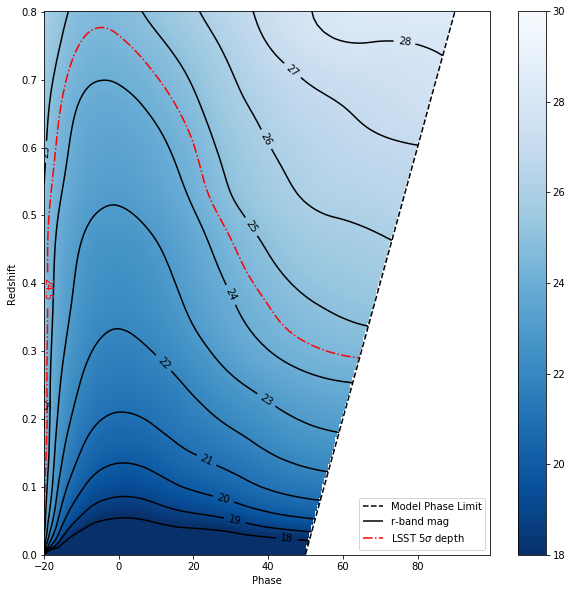

In [4]:
sn_model = sncosmo.Model('salt2-extended')  # or salt2-extended, salt2-h17
filter_name = 'lsstr'
redshift_range = (.001, .81, .01)
phase_range = (-20, 100, .5)

redshift_arr = np.arange(*redshift_range)
phase_arr = np.arange(*phase_range)
mag_arr = calculate_magnitude(sn_model, redshift_arr, phase_arr, filter_name)
fig = plot_mag(redshift_arr, phase_arr, mag_arr)
